In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/data science/pepper disease/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2475 files belonging to 2 classes.


In [5]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [6]:
len(dataset)

78

In [7]:
for image_batch,label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 0 1 0 0 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1]


In [8]:
for image_batch,label_batch in dataset.take(1):
  print(image_batch[0].numpy())
  

[[[142. 135. 142.]
  [149. 142. 149.]
  [152. 145. 152.]
  ...
  [133. 124. 129.]
  [134. 125. 130.]
  [112. 103. 108.]]

 [[146. 139. 146.]
  [151. 144. 151.]
  [155. 148. 155.]
  ...
  [ 83.  74.  79.]
  [126. 117. 122.]
  [116. 107. 112.]]

 [[146. 139. 146.]
  [147. 140. 147.]
  [152. 145. 152.]
  ...
  [131. 122. 127.]
  [111. 102. 107.]
  [109. 100. 105.]]

 ...

 [[166. 157. 160.]
  [187. 178. 181.]
  [176. 167. 170.]
  ...
  [130. 120. 119.]
  [108.  98.  97.]
  [132. 122. 121.]]

 [[152. 143. 146.]
  [173. 164. 167.]
  [159. 150. 153.]
  ...
  [112. 102. 101.]
  [114. 104. 103.]
  [140. 130. 129.]]

 [[177. 168. 171.]
  [203. 194. 197.]
  [171. 162. 165.]
  ...
  [112. 102. 101.]
  [124. 114. 113.]
  [129. 119. 118.]]]


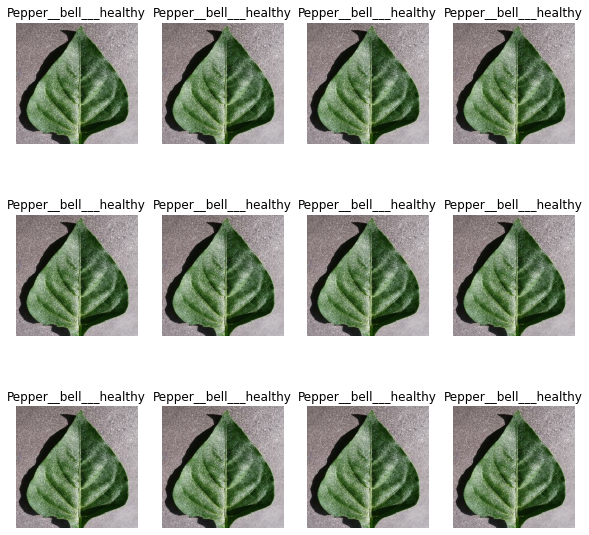

In [9]:
plt.figure(figsize=(10, 10))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")
 

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
len(train_ds)

62

In [13]:
len(test_ds)

9

In [14]:
len(val_ds)

7

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [17]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2
model = models.Sequential([
                          resize_and_rescale,
                           data_augmentation,
                         layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
]) 


In [19]:
model.build(input_shape=input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
62/62 [==============================] - 579s 4s/step - loss: 0.5688 - accuracy: 0.7071 - val_loss: 0.5236 - val_accuracy: 0.7634
Epoch 2/50
62/62 [==============================] - 236s 4s/step - loss: 0.2667 - accuracy: 0.9170 - val_loss: 0.3800 - val_accuracy: 0.9286
Epoch 3/50
62/62 [==============================] - 236s 4s/step - loss: 0.1733 - accuracy: 0.9552 - val_loss: 0.2047 - val_accuracy: 0.9777
Epoch 4/50
62/62 [==============================] - 234s 4s/step - loss: 0.1011 - accuracy: 0.9735 - val_loss: 0.1121 - val_accuracy: 0.9777
Epoch 5/50
62/62 [==============================] - 234s 4s/step - loss: 0.0786 - accuracy: 0.9781 - val_loss: 0.0789 - val_accuracy: 0.9821
Epoch 6/50
62/62 [==============================] - 232s 4s/step - loss: 0.0417 - accuracy: 0.9893 - val_loss: 0.1450 - val_accuracy: 0.9688
Epoch 7/50
62/62 [==============================] - 232s 4s/step - loss: 0.0673 - accuracy: 0.9812 - val_loss: 0.0655 - val_accuracy: 0.9911
Epoch 8/50
62

In [23]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 14s 889ms/step - loss: 0.0307 - accuracy: 0.9931


In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

first image to predict
actual label: Pepper__bell___healthy
predicted label: Pepper__bell___healthy


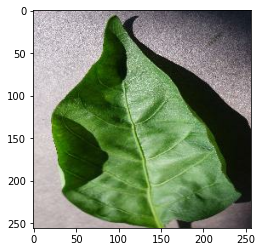

In [25]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [26]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

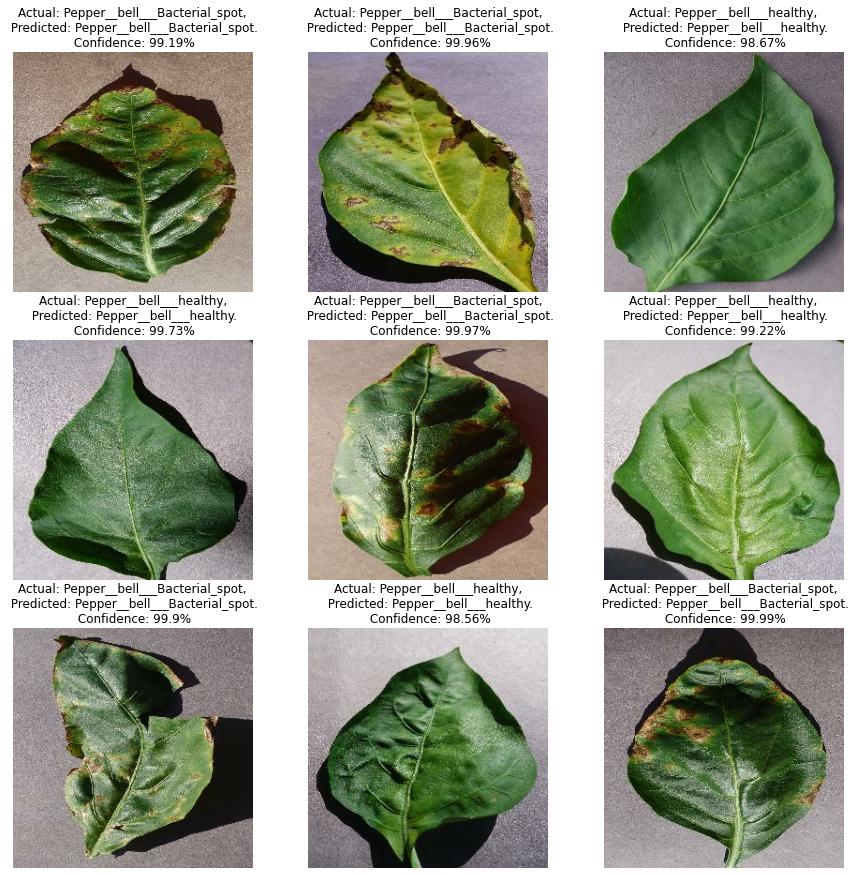

In [27]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [29]:
model.save("/content/drive/MyDrive/data science/models/pepper.h5")